In [1]:
'''
For directed graphs:
1) For a given graph G (N x M), perform SVD on its adjacency matrix i.e G_adj = U @ S @ V.T. 
   NOTE: S's diagonal is descendingly sorted. Also, convert values to 0 where user-item preference is not available. However, store the original unconverted form somewhere as well.
2) U (N x M), S(M x M), V(M x M). For k < I, let U_k be first k columns of U, S_k be the first k rows and columns of S, V_k be the first k columns of V. Then, G'_adj = (U_k @ S_k) @ V_k.T
3) Assuming U_k @ S_k as P and V_k as Q we have G`_adj = P @ Q.T
4) Recreate the graph using G' using G'_adj. (use 1 in G'_adj when G_adj_i_j > 0. 5, else use 0) 
5) Perform graph alignment on G' using G. Let the retuned permutation be X on users and Y on items.
6) Apply X on rows of P and apply Y on rows of Q.
7) Using this initialization of the values of P and Q, apply gradient descent element wise using RMSE on G_adj and G'_adj.
   NOTE: refer to https://towardsdatascience.com/recommendation-system-matrix-factorization-d61978660b4b
8) Report evaluation metrics and training time. 
9) Repeat the entire process skipping steps 5 and 6.
10) Report the differences between both the processes.
'''

"\nFor directed graphs:\n1) For a given graph G (N x M), perform SVD on its adjacency matrix i.e G_adj = U @ S @ V.T. \n   NOTE: S's diagonal is descendingly sorted. Also, convert values to 0 where user-item preference is not available. However, store the original unconverted form somewhere as well.\n2) U (N x M), S(M x M), V(M x M). For k < I, let U_k be first k columns of U, S_k be the first k rows and columns of S, V_k be the first k columns of V. Then, G'_adj = (U_k @ S_k) @ V_k.T\n3) Assuming U_k @ S_k as P and V_k as Q we have G`_adj = P @ Q.T\n4) Recreate the graph using G' using G'_adj. (use 1 in G'_adj when G_adj_i_j > 0. 5, else use 0) \n5) Perform graph alignment on G' using G. Let the retuned permutation be X on users and Y on items.\n6) Apply X on rows of P and apply Y on rows of Q.\n7) Using this initialization of the values of P and Q, apply gradient descent element wise using RMSE on G_adj and G'_adj.\n   NOTE: refer to https://towardsdatascience.com/recommendation-syst

In [2]:
# importing the libraries
import networkx as nx
from stochastic import *
from networkx.algorithms import bipartite
import numpy as np

In [3]:
user_item_graph = nx.Graph()
user_item_graph.add_nodes_from([i for i in range(0, 10)], bipartite=0) # users are indexed from 0 to 9
user_item_graph.add_nodes_from([i for i in range(10, 15)], bipartite=1) # items are indexed from 10 to 14
user_item_graph.add_edges_from([(0, 12), (0, 14), (1, 10), (1, 12), (2, 13), (2, 14), (3, 14), (3, 11), (4, 10), (4, 12), (4, 14)])
user_item_graph.add_edges_from([(5, 13), (5, 14), (6, 10), (6, 11), (6, 13), (7, 13), (8, 10), (8, 14), (9, 12)])

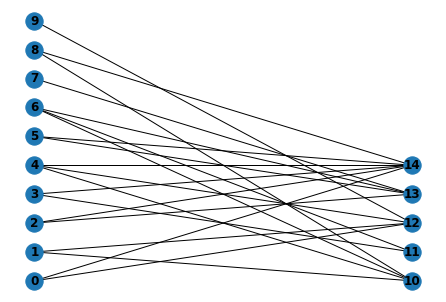

In [4]:
X, Y = bipartite.sets(user_item_graph)
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2
nx.draw(user_item_graph, with_labels=True, pos=pos, font_weight='bold')

In [5]:
user_item_adjacency = nx.adjacency_matrix(user_item_graph).todense()
print(user_item_adjacency)

[[0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 1 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0 0 0 0 0 0]
 [1 1 0 0 1 0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 1 1 1 0 0 0 0 0 0 0]
 [1 0 1 1 1 1 0 0 1 0 0 0 0 0 0]]


In [6]:
u, s, vh = np.linalg.svd(user_item_adjacency)

In [7]:
u_3 = u[:,0:3]
s_3 = np.diag(s)[0:3, 0:3]
vh_3 = vh[0:3, :]
g1 = u_3 @ s_3 @ vh_3
g1_adj = (g1 > 0.5).astype(int)
print(g1_adj)

[[0 0 0 0 0 0 0 0 0 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 1 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 0 1 0 0 0 0 0 0]]


In [8]:
user_item_estimation = nx.from_numpy_matrix(g1_adj)

<generator object isolates.<locals>.<genexpr> at 0x000002579E327348>


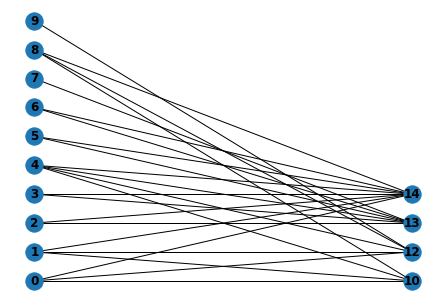

In [10]:
isolated_nodes = nx.isolates(user_item_estimation)
print(isolated_nodes)
user_item_estimation.remove_nodes_from(isolated_nodes)
X1, Y1 = bipartite.sets(user_item_estimation)
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(X1) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(Y1) ) # put nodes from Y at x=2
nx.draw(user_item_estimation, with_labels=True, pos=pos, font_weight='bold')